#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Загрузка и подключение библиотек

In [1]:
!pip install --upgrade scikit-learn -q
!pip install catboost -q
!pip install lightgbm -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import time

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, RandomizedSearchCV

RANDOM_STATE=42

In [3]:
try:
    data=pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except FileNotFoundError:
    data=pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


<b>Промежуточный вывод:</b>
- Были загружены и импортированны библиотеки
- Были загруженны данные 
- Пропуски в данных отсутствуют
- datetime: Дата и время заказа такси (тип данных: datetime64[ns])
- num_orders: Количество заказов такси (целевой признак, тип данных: int64)

## Анализ

Вывод факторного анализа

In [7]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Минимальное количество заказов за час составляет 0, а максимальное — 119.

Построим график вызовов по часам

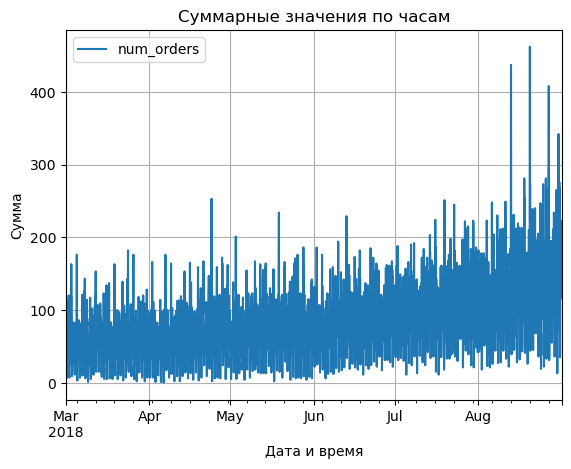

In [8]:
data=data.resample('1h').sum()
data.plot(title='Суммарные значения по часам', xlabel='Дата и время', ylabel='Сумма')
plt.grid(True);

Построим график вызовов по дням

<Figure size 1500x1000 with 0 Axes>

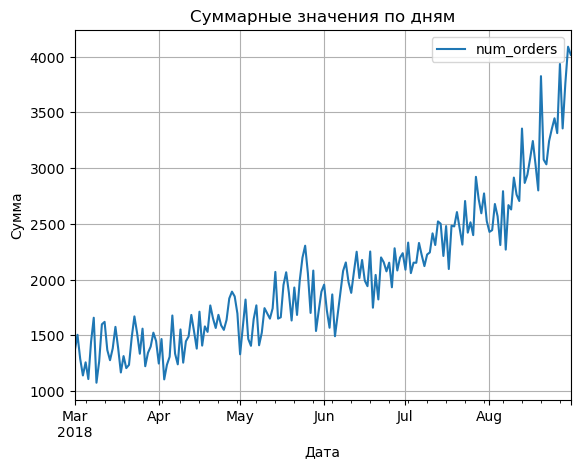

In [9]:
plt.figure(figsize=(15,10))
data.resample('1D').sum().plot(title='Суммарные значения по дням', xlabel='Дата', ylabel='Сумма')
plt.grid(True);

Построим график скользяцего (500 наблюдений)

<Figure size 1500x1000 with 0 Axes>

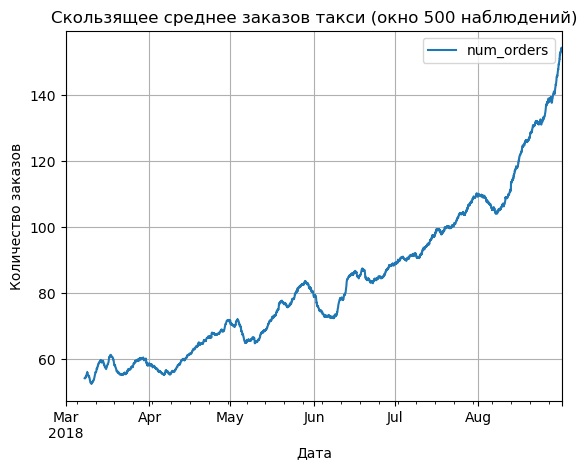

In [10]:
plt.figure(figsize=(15,10))
data.rolling(168).mean().plot(title='Скользящее среднее заказов такси (окно 500 наблюдений)', 
                              xlabel='Дата', 
                              ylabel='Количество заказов')
plt.grid(True);

Построим графики с трендом, сезонностью и остатками по всем дням 

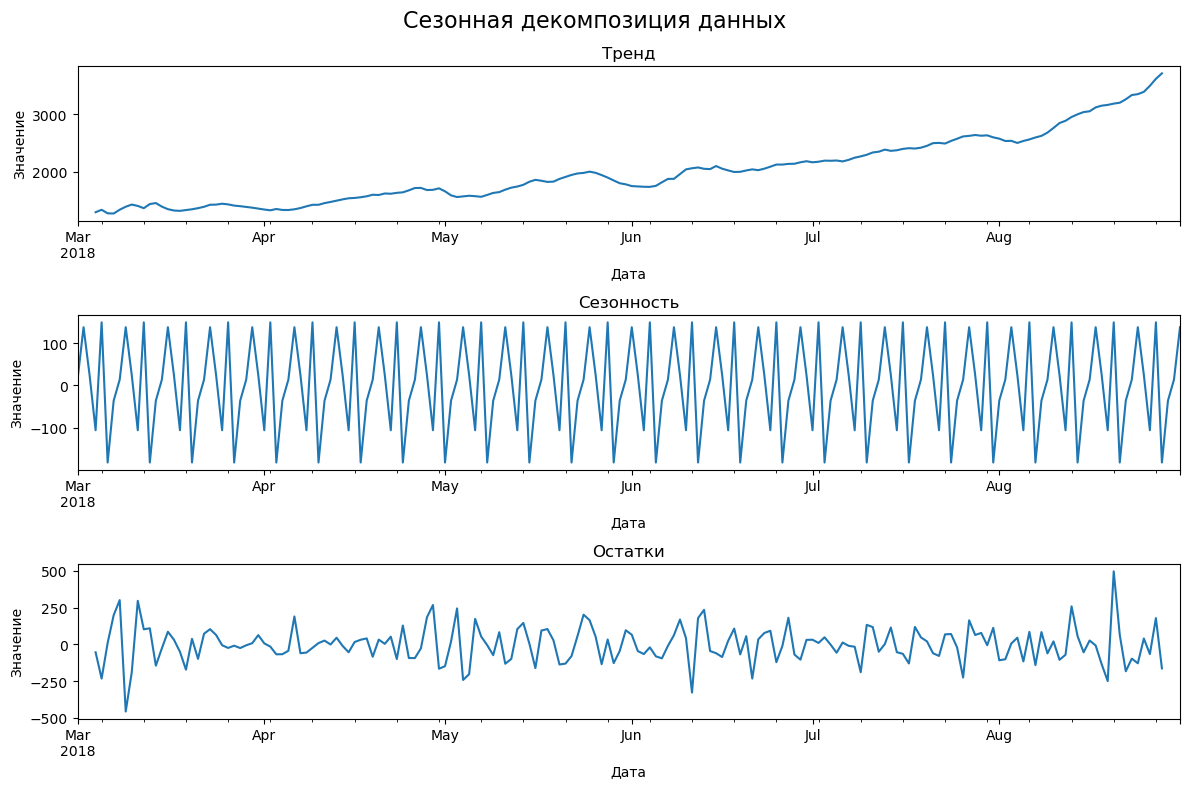

In [11]:
decomposed=seasonal_decompose(data.resample('1D').sum(), model='additive')
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

decomposed.trend.plot(ax=axes[0])
axes[0].set_title('Тренд')
axes[0].set_xlabel('Дата')
axes[0].set_ylabel('Значение')

decomposed.seasonal.plot(ax=axes[1])
axes[1].set_title('Сезонность')
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('Значение')

decomposed.resid.plot(ax=axes[2])
axes[2].set_title('Остатки')
axes[2].set_xlabel('Дата')
axes[2].set_ylabel('Значение')

fig.suptitle('Сезонная декомпозиция данных', fontsize=16)
plt.tight_layout();

Построим графики с трендом, сезонностью и остатками в диапазоне по часам

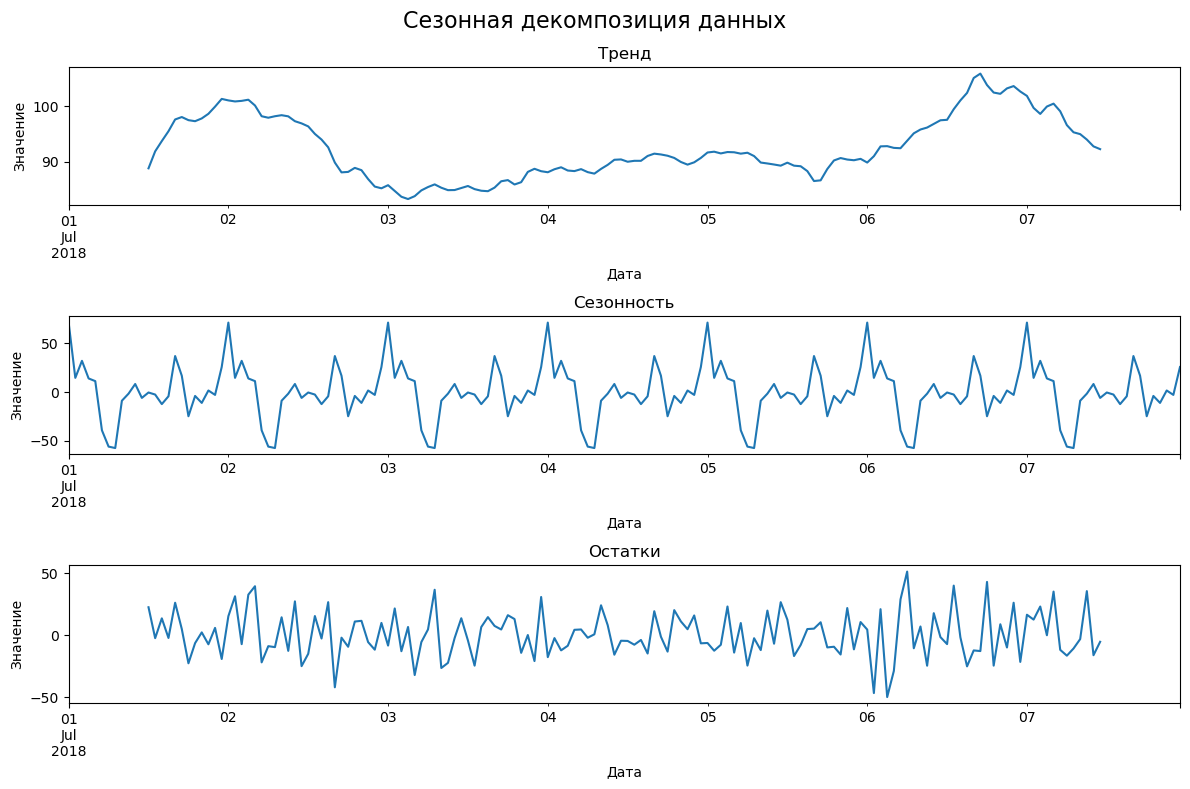

In [12]:
decomposed=seasonal_decompose(data['2018-07-01':'2018-07-07'].resample('1h').sum(), model='additive')
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

decomposed.trend.plot(ax=axes[0])
axes[0].set_title('Тренд')
axes[0].set_xlabel('Дата')
axes[0].set_ylabel('Значение')

decomposed.seasonal.plot(ax=axes[1])
axes[1].set_title('Сезонность')
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('Значение')

decomposed.resid.plot(ax=axes[2])
axes[2].set_title('Остатки')
axes[2].set_xlabel('Дата')
axes[2].set_ylabel('Значение')

fig.suptitle('Сезонная декомпозиция данных', fontsize=16)
plt.tight_layout();

Вывод разности временного ряда

In [13]:
print(data.shift(fill_value=0))

                     num_orders
datetime                       
2018-03-01 00:00:00           0
2018-03-01 01:00:00         124
2018-03-01 02:00:00          85
2018-03-01 03:00:00          71
2018-03-01 04:00:00          66
...                         ...
2018-08-31 19:00:00         207
2018-08-31 20:00:00         136
2018-08-31 21:00:00         154
2018-08-31 22:00:00         159
2018-08-31 23:00:00         223

[4416 rows x 1 columns]


График разности временного ряда

<Figure size 1500x1000 with 0 Axes>

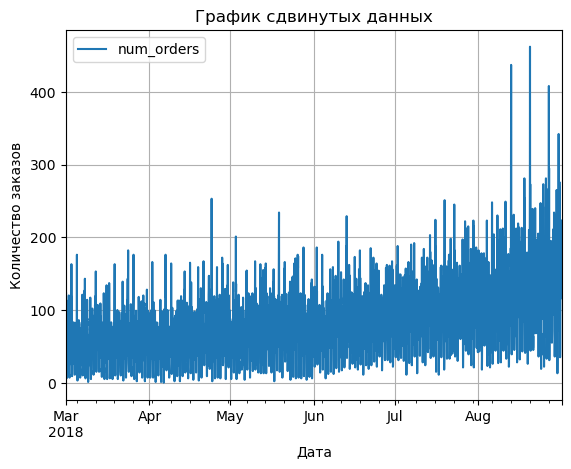

In [14]:
plt.figure(figsize=(15, 10))
data.shift(fill_value=0).plot(title='График сдвинутых данных', 
                              xlabel='Дата', 
                              ylabel='Количество заказов')
plt.grid(True);

Построим график скользящей среднего и стандартного отклонения

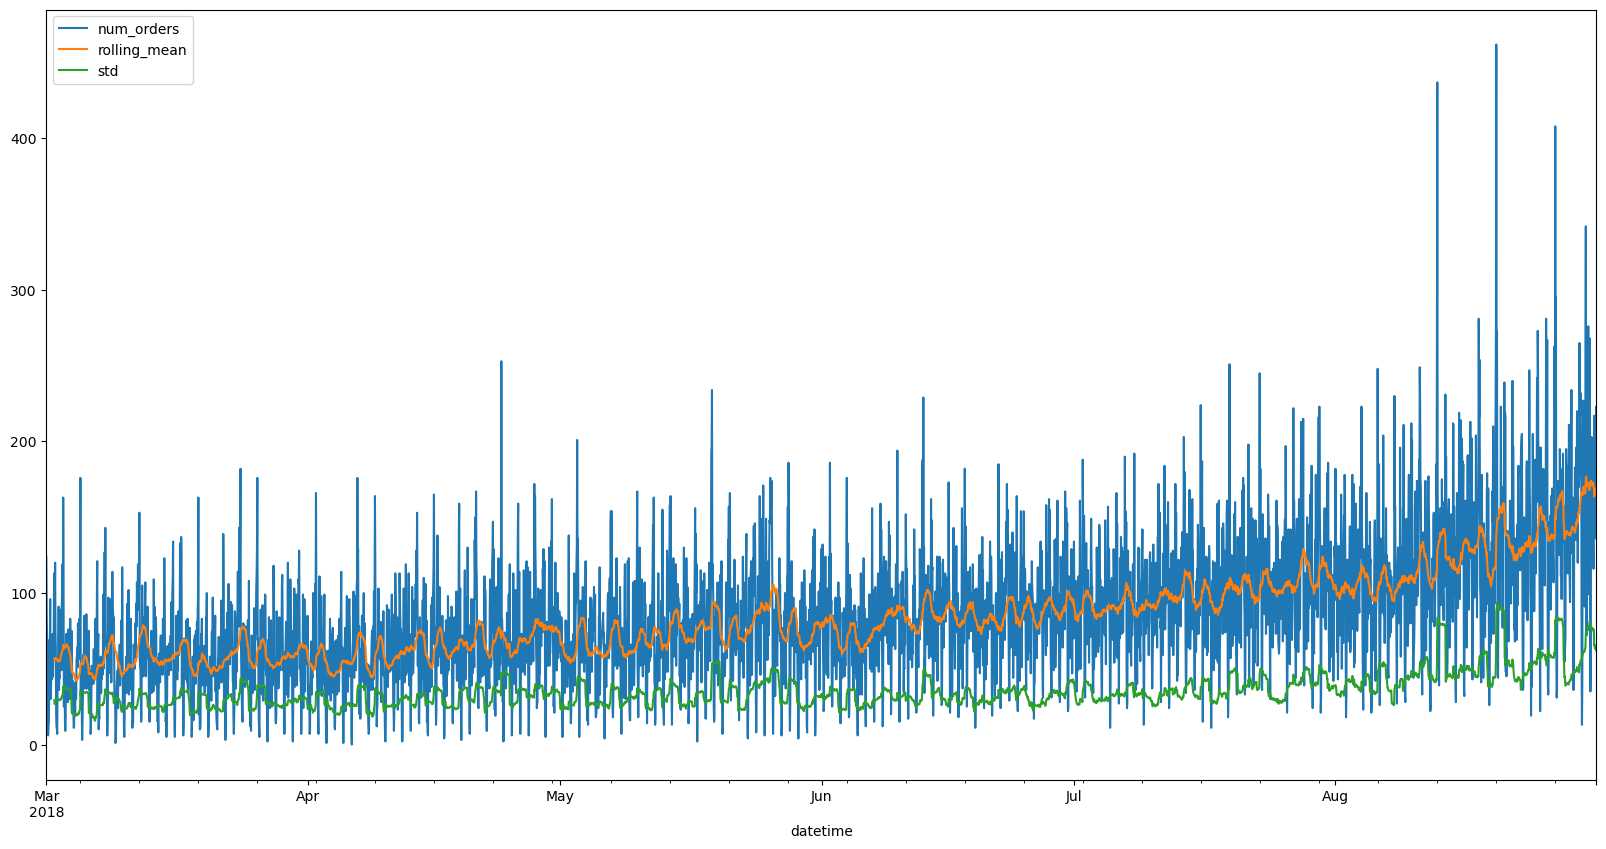

In [15]:
data_copy=data.copy()
data_copy['rolling_mean'] = data_copy.rolling(24).mean()
data_copy['std'] = data_copy['num_orders'].rolling(24).std()
data_copy.plot(figsize=(20, 10));

График с разницей между текущим и предыдущим значениями, добавим столбцы со скользящим средним и стандартным отклонением

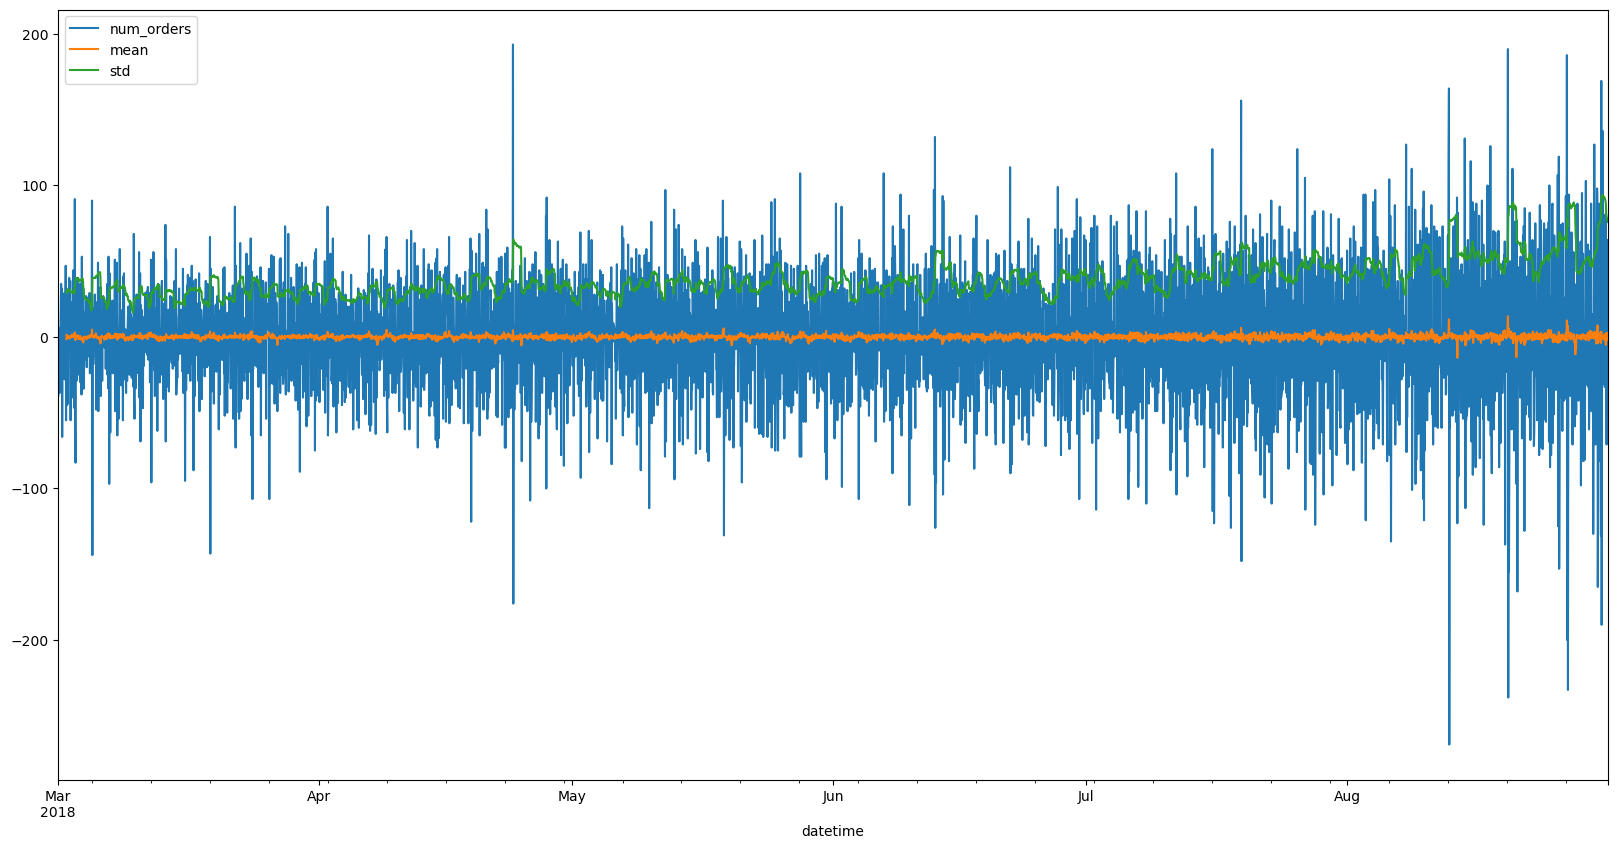

In [16]:
df_shift = data - data.shift()
df_shift['mean'] = df_shift['num_orders'].rolling(24).mean()
df_shift['std'] = df_shift['num_orders'].rolling(24).std()
df_shift.plot(figsize=(20, 10));

<b>Промежуточный вывод:</b>

На этом этапе был проведен анализ данных с использованием метода декомпозиции, который выявил следующие аспекты:

- Тренд: Наблюдается общий тренд на увеличение количества заказов такси в течение часа, что, вероятно, связано с ростом компании. Гипотеза о том, что бизнес, связанный с такси, не имеет месячной сезонности, требует подтверждения или опровержения на основе данных за несколько лет.

- Сезонность: На графиках четко видна суточная сезонность. Количество заказов ночью стремится к нулю, в то время как вечерний час пик характеризуется самым сильным спросом на услуги такси.

## Обучение

Обучим три модели в качестве моделей используем LinearRegression, CatBoostRegressor и LightGBM.

Создадим дополнительные признаки для временного ряда, включая день недели, час дня, лаговые значения и скользящее среднее

In [17]:
def make_features(df, max_lag, rolling_mean_size):
    df['day_of_week'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    df = df.dropna()

Применим функцию для создания признаков с лагом до 24 часов и 48-часовым скользящим средним

In [18]:
make_features(data, 24, 48)

Удаление дубликатов

In [19]:
data=data.dropna()

Вывод данных после проделанной операции

In [20]:
data.head()

,num_orders,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,163,5,0,72.0,119.0,101.0,93.0,49.0,89.0,83.0,...,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,59.791667
2018-03-03 01:00:00,108,5,1,163.0,72.0,119.0,101.0,93.0,49.0,89.0,...,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,60.604167
2018-03-03 02:00:00,25,5,2,108.0,163.0,72.0,119.0,101.0,93.0,49.0,...,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,61.083333
2018-03-03 03:00:00,64,5,3,25.0,108.0,163.0,72.0,119.0,101.0,93.0,...,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,60.125000
2018-03-03 04:00:00,44,5,4,64.0,25.0,108.0,163.0,72.0,119.0,101.0,...,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,60.083333


Разделим данные на обучающую и тестовую выборки

In [21]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Создадим функцию расчета RMSE 

In [22]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5

In [23]:
RMSE_score = make_scorer(RMSE, greater_is_better=False)

Обучим модель линейной регрессии с использованием кросс-валидации по временным рядам

In [24]:
%%time
tscv = TimeSeriesSplit(n_splits=3)
model_lr = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None)
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
regression_cv_score = pd.Series(cross_val_score(model_lr, features_train_scaled, target_train, scoring=RMSE_score, cv=tscv)).mean() * (-1)
print('Среднее качество модели линейной регрессии на кросс-валидации:', regression_cv_score)

Среднее качество модели линейной регрессии на кросс-валидации: 28.2413301694197
CPU times: total: 328 ms
Wall time: 420 ms


Обучим модель CatBoost с использованием кросс-валидации по временным рядам 

In [26]:
%%time
tscv = TimeSeriesSplit(n_splits=3)
hyperparams = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'iterations': [100, 200, 300]
}
model_cb = CatBoostRegressor(verbose=0)
random_search = RandomizedSearchCV(model_cb, param_distributions=hyperparams, n_iter=50, scoring=RMSE_score, cv=tscv, random_state=RANDOM_STATE, n_jobs=-1)
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
random_search.fit(features_train_scaled, target_train)
print('Лучшие гиперпараметры:', random_search.best_params_)
print('Лучший скор:', random_search.best_score_ * (-1))

Лучшие гиперпараметры: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 200, 'depth': 6}
Лучший скор: 25.789663442462302
CPU times: total: 6.38 s
Wall time: 1min 35s


Обучим модель LightGBM с использованием кросс-валидации по временным рядам 

In [27]:
%%time
tscv = TimeSeriesSplit(n_splits=3)
model_lgb = lgb.LGBMRegressor(verbose=-1)
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
lightgbm_cv_score = pd.Series(cross_val_score(model_lgb, features_train_scaled, target_train, scoring=RMSE_score, cv=tscv)).mean() * (-1)
print('Среднее качество модели LightGBM на кросс-валидации:', lightgbm_cv_score)

Среднее качество модели LightGBM на кросс-валидации: 26.816661763354677
CPU times: total: 1.64 s
Wall time: 591 ms


Модель, которая оказалась лучшей на этапе исследования.

In [28]:
print( random_search.best_estimator_)

<b>Промежуточный вывод:</b> 
Данные были разделены на тестовую и тренировочную выборки. Затем были обучены три модели: LinearRegression, CatBoostRegressor и LightGBM. Для нормализации данных был применен метод StandardScaler, а для оценки моделей — кросс-валидация с использованием TimeSeriesSplit.

Результаты кросс-валидации:
- LinearRegression показала среднее качество модели 28.2413301694197 с быстрым временем выполнения (422 мс CPU, 505 мс Wall time).
- CatBoostRegressor достигла лучшего скора 25.79109747969321, но с более длительным временем выполнения (58.8 с CPU, 9.11 с Wall time).
- LightGBM продемонстрировала хорошее качество модели 26.816661763354677 с умеренным временем выполнения (1.19 с CPU, 311 мс Wall time).

Модель CatBoostRegressor показала лучшее качество (наименьшее значение RMSE) среди трех моделей, хотя и потребовала больше времени для обучения.

## Тестирование

Проверим модель на адекватность, сравнивая предсказанные значения с предыдущими значениями целевой переменной

In [29]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]  

rmse_adequacy = RMSE(target_test, pred_previous)
print(f'RMSE для проверки модели на адекватность: {round(rmse_adequacy, 3)}')

RMSE для проверки модели на адекватность: 59.019


Для проверки реализуем метод на тестовых данных

RMSE на тестовой выборке: 41.22080812787201


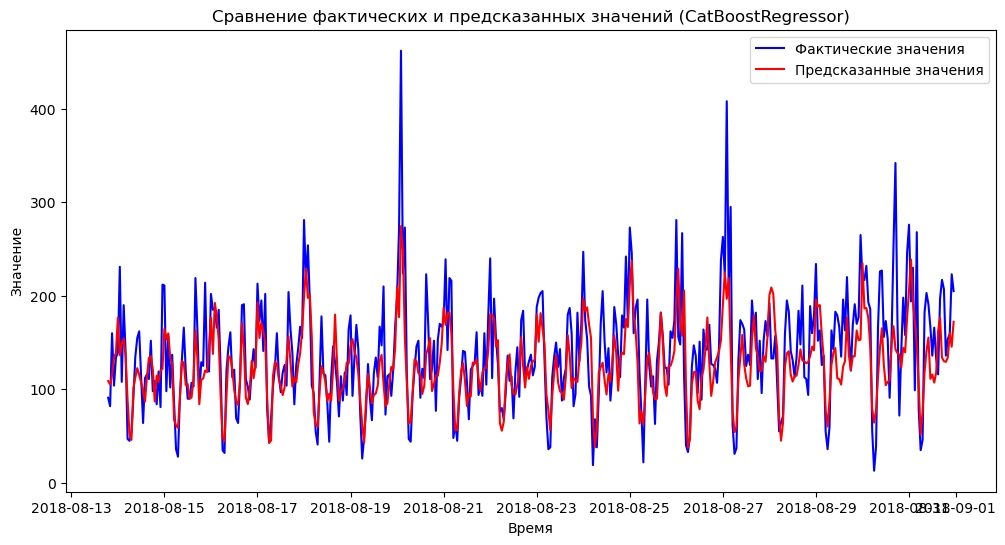

In [30]:
best_model_cb = random_search.best_estimator_
target_predict_cb = best_model_cb.predict(scaler.transform(features_test))
final_RMSE_CB = mean_squared_error(target_test, target_predict_cb) ** 0.5

figsize = (12, 6)

plt.figure(figsize=figsize)
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         target_predict_cb,
         'r-')
plt.title('Сравнение фактических и предсказанных значений (CatBoostRegressor)')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend(['Фактические значения', 'Предсказанные значения'])
print("RMSE на тестовой выборке:", final_RMSE_CB);

## Общий вывод

<b>Вывод:</b>
1. Проверка модели на адекватность:
- RMSE для проверки модели на адекватность: 59.019
- Это значение RMSE указывает на то, что модель демонстрирует разумную адекватность, хотя и с некоторыми ошибками в предсказаниях.
2. Тестирование на тестовой выборке:
- RMSE на тестовой выборке: 41.22080812787201
- Это значение RMSE на тестовой выборке ниже, чем при проверке на адекватность, что указывает на то, что модель хорошо обобщает данные и не переобучается.
3. Лучшие гиперпараметры:
- Гиперпараметры модели: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 200, 'depth': 6}
- Эти гиперпараметры были определены как оптимальные для данной модели, что позволило достичь лучшего качества предсказаний.

Выполнение задачи:
Все три модели успешно выполнили задачу, так как их RMSE на тестовой выборке меньше 48.0.

Общий вывод:
- CatBoostRegressor является наиболее эффективной моделью среди трех рассмотренных, так как она показала лучшее качество как на кросс-валидации, так и на тестовой выборке.
- LightGBM также показал хорошие результаты, но немного уступает CatBoostRegressor.
- LinearRegression показала худшие результаты по сравнению с другими моделями, хотя и выполнила задачу.

Таким образом, если нужно выбрать одну модель для дальнейшего использования, CatBoostRegressor будет лучшим выбором.